В таблице ниже приведена выборка абонентов и показателей по ним (ежемесячные начисления, трафик, тип устройства)
Необходимо подготовить выборку к анализу (выделить или исключить нехарактерные значения) и сделать сегментацию, выделив 3-5 характерных сегментов на основе профиля абонента. Обосновать выбор критериев и сделать выводы.


In [230]:
#импортирую нужные библиотеки
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta, time
import math as mth
import scipy.stats as st
from scipy.stats import ttest_ind
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from IPython.display import display
import plotly.express as px

Импорт файла эксель с табилцей

In [231]:
data = pd.read_excel("C:/Users/ILYUSHA/Downloads/C897E280_1АвтоматическиВосстановлено.xlsx", sheet_name='Лист3')

Просмотр общей информации о файле

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14636 entries, 0 to 14635
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              14636 non-null  int64  
 1   category        14590 non-null  object 
 2   revenue         14636 non-null  float64
 3   tr_voice_min    14636 non-null  float64
 4   tr_data_mb      14636 non-null  float64
 5   tr_rouming_min  14636 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 686.2+ KB


In [233]:
data.isna().sum() #Вывожу количество пропусков в столбцах

id                 0
category          46
revenue            0
tr_voice_min       0
tr_data_mb         0
tr_rouming_min     0
dtype: int64

Пропуски есть только в столбце category. Всего строк в данных 14636, пропусков 46. Их можно удалить, так как они занимают малую долю

In [234]:
data = data.dropna ()
data.isna().sum()

id                0
category          0
revenue           0
tr_voice_min      0
tr_data_mb        0
tr_rouming_min    0
dtype: int64

### Обработка аномальных значений

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке.
Например, отрицательные значения в полях трафика. Проверим их наличие

In [235]:
print('Число отрицательных значений в столбце tr_voice_min = ',len(data.query('tr_voice_min<0')))

Число отрицательных значений в столбце tr_voice_min =  5


In [236]:
print('Число отрицательных значений в столбце tr_data_mb = ',len(data.query('tr_data_mb<0')))

Число отрицательных значений в столбце tr_data_mb =  3


In [237]:
print('Число отрицательных значений в столбце tr_rouming_min = ',len(data.query('tr_rouming_min<0')))

Число отрицательных значений в столбце tr_rouming_min =  1


In [238]:
print('Число отрицательных значений в столбце revenue = ',len(data.query('revenue<0')))

Число отрицательных значений в столбце revenue =  63


In [239]:
len(data)

14590

Так как таких записей всего 72, то удалю их из таблицы

In [240]:

data = data.query('tr_voice_min >= 0')
data = data.query('tr_data_mb >= 0')
data = data.query('tr_rouming_min >= 0')
data = data.query('revenue >= 0')

In [241]:
print('Теперь число отрицательных значений в столбце tr_voice_min = ',len(data.query('tr_voice_min<0')))

Теперь число отрицательных значений в столбце tr_voice_min =  0


In [242]:
print('Теперь Число отрицательных значений в столбце tr_data_mb = ',len(data.query('tr_data_mb<0')))

Теперь Число отрицательных значений в столбце tr_data_mb =  0


In [243]:
print('Теперь Число отрицательных значений в столбце tr_rouming_min = ',len(data.query('tr_rouming_min<0')))

Теперь Число отрицательных значений в столбце tr_rouming_min =  0


In [244]:
print('Теперь Число отрицательных значений в столбце revenue = ',len(data.query('revenue<0')))

Теперь Число отрицательных значений в столбце revenue =  0


**РАБОТА С ДУБЛИКАТАМИ**

In [245]:
print('В данных есть {} дубликатов'.format( data.duplicated().sum()))

В данных есть 25 дубликатов


Удалю их, так как они занимают малую долю

In [246]:
data = data.drop_duplicates(keep='first')# удаляю дубликаты, оставляю первую строку каждого дубликата


***ТАким образом, я очистил данных от дублей, пропусков, отрицательных значений***

**РАБОТА С ВЫБРОСАМИ**

Работа с выбросами играет важное значение, так как результаты анализа датасета с выбросами и без могут отличаться. Поэтому при презентации результатов стоит это упомянуть. 

Также для анализа можно использовать оба датасета (очищенный от выбросов и нет) и затем сравнить их результаты

Выручка и виды трафика в таблице представлены в разных единицах(руб, мин, мб), поэтому исследовать их на одном боксплоте некорректно.

<AxesSubplot:>

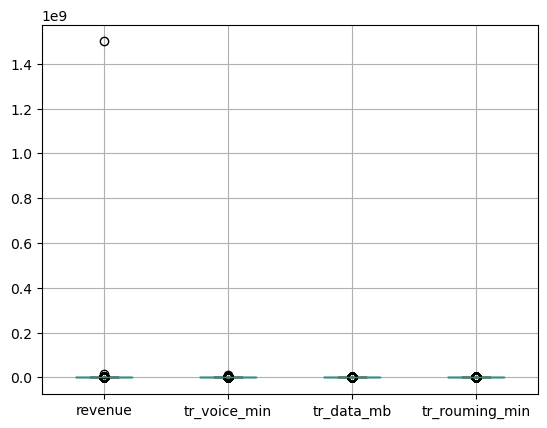

In [247]:
data.boxplot(column=['revenue','tr_voice_min', 'tr_data_mb', 'tr_rouming_min'])

**Рассмотрю выручку (начисления)**

In [248]:
(data['revenue']/1000000).describe()

count    14493.000000
mean         0.107949
std         12.461270
min          0.000000
25%          0.000318
50%          0.000758
75%          0.001759
max       1500.098005
Name: revenue, dtype: float64

Привел данные к млн. Видно, что данные сильно искажены из за выбросов, медиана и среднее значение сильно отличаются. 

<AxesSubplot:>

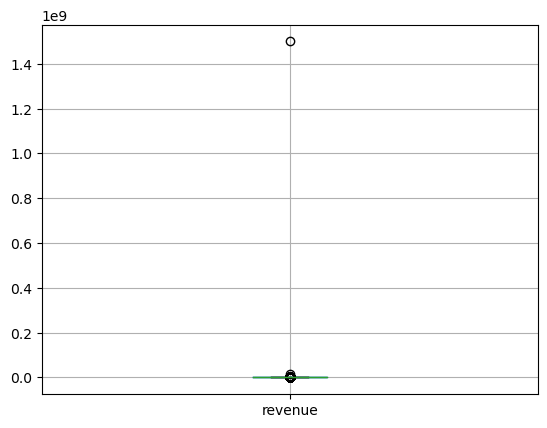

In [249]:
data.boxplot(column=['revenue'])

По такому ящику можно сказать, что значение ~1.5 млрд - выброс.
Рассмотрю также график более детально

[(0.0, 20000.0)]

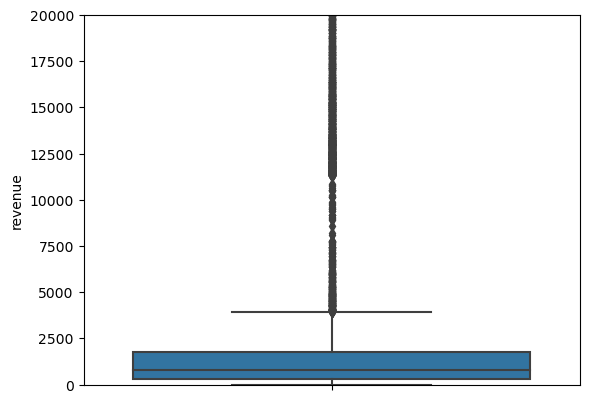

In [250]:
a = sns.boxplot(y=data["revenue"])
a.set(ylim=(0,20000))

В соответствии с правилами анализа данных выбросами считаются те значения, которые лежат выше верхней границы (75% + 1,5IQR)

In [251]:
IQR1_5_rev = np.percentile(data[['revenue']], 75) + 1.5*(np.percentile(data[['revenue']], 75)-np.percentile(data[['revenue']], 25))

In [252]:
print('Таких данных в выборке: ', len(data.query('revenue > @IQR1_5_rev')),'или ',  round(len(data.query('revenue > @IQR1_5_rev'))/len(data)*100,2), '%')

Таких данных в выборке:  2009 или  13.86 %


13.8 % - является весомым показателем. Удалив их, результаты могут быть искажены. Поэтому оставим в выборке данные до 99 персентиля

In [253]:
pc99 = np.percentile(data[['revenue']], 99)

In [254]:
clean_data = data. query('revenue<= @pc99') 

In [255]:
clean_data['revenue'].describe()

count    14348.000000
mean      2645.811694
std       5280.206236
min          0.000000
25%        315.000508
50%        748.786700
75%       1693.210517
max      34436.111100
Name: revenue, dtype: float64

Теперь разница между средним и медианой значительно сократилась

**Работа с голосовым трафиком (мин)**

In [256]:
clean_data['tr_voice_min'].describe()

count    14348.000000
mean       935.804319
std       1975.644444
min          0.000000
25%          3.993750
50%         57.400000
75%        960.814583
max      37159.952780
Name: tr_voice_min, dtype: float64

разница между средним и медианой кратка почти 20, что говорит о выбросах

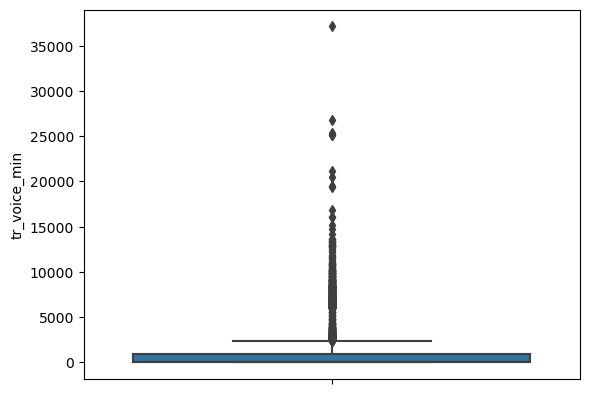

In [257]:
a = sns.boxplot(y=clean_data["tr_voice_min"])

В голосовом трафике также наблюдаются выбросы. Рассмотрим какую долю они занимают

In [258]:
IQR1_5_voice = np.percentile(clean_data[['tr_voice_min']], 75) + 1.5*(np.percentile(clean_data[['tr_voice_min']], 75)-np.percentile(clean_data[['tr_voice_min']], 25))

In [259]:
print('Таких данных в выборке: ', len(clean_data.query('tr_voice_min > @IQR1_5_voice')),'или ',  round(len(clean_data.query('tr_voice_min > @IQR1_5_voice'))/len(clean_data)*100,2), '%')

Таких данных в выборке:  1293 или  9.01 %


9 % - также является большим показателем. Удалив их, результаты могут быть искажены. Поэтому оставим в выборке данные до 99 персентиля

In [260]:
pc99_сlean = np.percentile(clean_data[['tr_voice_min']], 99)

In [261]:
clean_data = clean_data. query('tr_voice_min<= @pc99_сlean') 

In [262]:
clean_data['tr_voice_min'].describe()

count    14204.000000
mean       829.279436
std       1627.976217
min          0.000000
25%          3.736111
50%         56.180556
75%        933.651390
max       8694.347222
Name: tr_voice_min, dtype: float64

Разница между средним и медианой незначительно изменилась

**Работа с трафиком передачи данных (мб)**

In [263]:
clean_data['tr_data_mb'].describe()

count    1.420400e+04
mean     2.404891e+04
std      4.867865e+04
min      0.000000e+00
25%      6.767969e+02
50%      3.130255e+03
75%      5.035766e+04
max      1.772188e+06
Name: tr_data_mb, dtype: float64

разница между средним и медианой ~8 раз

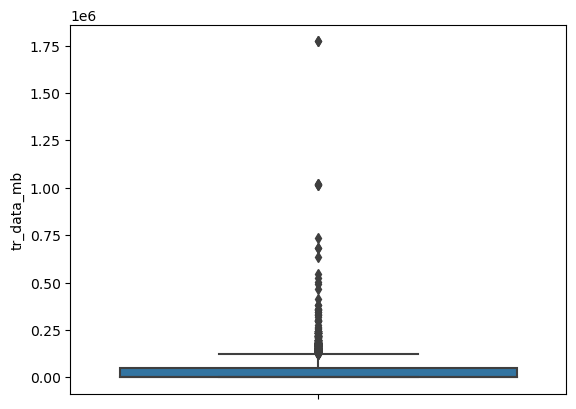

In [264]:
a = sns.boxplot(y=clean_data["tr_data_mb"])

В tr_data_mb также наблюдаются выбросы. Рассмотрим какую долю они занимают

In [265]:
IQR1_5_mb = np.percentile(clean_data[['tr_data_mb']], 75) + 1.5*(np.percentile(clean_data[['tr_data_mb']], 75)-np.percentile(clean_data[['tr_data_mb']], 25))

In [266]:
print('Таких данных в выборке: ', len(clean_data.query('tr_data_mb > @IQR1_5_mb')),'или ',  round(len(clean_data.query('tr_data_mb > @IQR1_5_mb'))/len(clean_data)*100,2), '%')

Таких данных в выборке:  325 или  2.29 %


2.29% можно удалить из выборки, сильного влияния на результат анализа это не окажет

In [267]:
clean_data = clean_data.query('tr_data_mb<=@IQR1_5_mb')

In [269]:
clean_data['tr_data_mb'].describe()

count     13879.000000
mean      19778.621759
std       30044.645260
min           0.000000
25%         529.320477
50%        2937.234217
75%       29985.710210
max      124810.079600
Name: tr_data_mb, dtype: float64

Разница между средним и медианой уменьшилась, но все равно остается огромной.

**Работа с трафиком в роуминге**

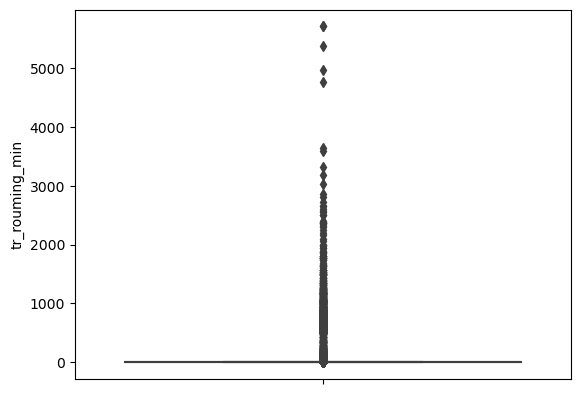

In [271]:
a = sns.boxplot(y=clean_data["tr_rouming_min"])

В tr_rouming_min также наблюдаются выбросы. Рассмотрим какую долю они занимают

In [272]:
IQR1_5_roum = np.percentile(clean_data[['tr_rouming_min']], 75) + 1.5*(np.percentile(clean_data[['tr_rouming_min']], 75)-np.percentile(clean_data[['tr_rouming_min']], 25))

In [273]:
print('Таких данных в выборке: ', len(clean_data.query('tr_rouming_min > @IQR1_5_roum')),'или ',  round(len(clean_data.query('tr_rouming_min > @IQR1_5_roum'))/len(clean_data)*100,2), '%')

Таких данных в выборке:  3107 или  22.39 %


Не буду ничего удалять, так как это 1/5 данных

**Таким образом, были проанализированы числовые данные**

были удалены из выборки аномально большие значения, которые способны сильно повляить на результат. В некоторых столбцах выбросы не были удалены, так как их доля слишком большая - удалив данные, результаты анализы могут исказиться.

In [284]:
print('из первоначальных данных было удалено ', round(100- len(clean_data)/len(data)*100,2), '%')

из первоначальных данных было удалено  4.24 %
